# Table of Contents
0. Initialization
1. Photometric Params
     * [Effective Radii Rn](#rnandn)
     * [The 'Spiking' Problem](#spiking)
     * [Sérsic Index n](#sersicindex)
2. Morphometric Params
    * [Concentrations $C_1$ and $C_2$](#cs)
    * [Asymmetries $A_1$ and $A_3$](#asymmetries)
    * [Smoothess $S_1$ and $S_3$](#smoothness)
    * [Gini and Entropy](#giniH)
    * [Spirality $\sigma_{\psi}$](#sigmapsi)
    * [$M_{20}$](#m20)
3. [LDA](#lda)
4. Appendixes    
    * [Catalog Class](#appclass)
    * [Plotting Utilities](#appB)

### If you are just reading this notebook skip **1. Initialization**

# 1. Initialization

Imports and autoreload

In [12]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.append('/data/github/mfmtk-utils/')
from mfmtkutils import *

Setting up Paths, Redshift Steps and Class Information

In [4]:
path = '/data/catalogs/FERENGI/flux/'


redshifts = ['0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.10', '0.12', 
             '0.14', '0.16', '0.18', '0.20', '0.25', '0.30', '0.35', '0.40', '0.45']

z = np.array(redshifts).astype(float)

T_type = np.loadtxt('/data/datasets/EFIGI_PGC.txt', usecols=[0, 1], dtype=str).T

Which parameters do we need? (in order)

In [5]:
photo_params = ['Mo', 'RnFit2D', 'nFit2D', 'Rp']
morpho_params = ['C1', 'C2', 'A1', 'A3', 'S1', 'S3',
                 'G', 'H', 'M20', 'sigma_psi']

Load a catalog for each redshift. We are using the **mfmtkutils.catalog** class

In [74]:
flux_cats = []
for z in redshifts:
    cat = catalog(path=path+z+'.mfmtk')
    flux_cats.append(cat)

Now we can reduce flux_cats to produce catalogs for each parameter, let's start with the photo ones

In [75]:
photo_catalogs = []
for j, param in enumerate(photo_params):
    flux = flux_cats[0].reduce(flux_cats, param).raw_catalog
    photo_catalogs.append(flux[1:].astype(float))
    
galaxies = flux_cats[0].raw_catalog[0]

And the same for morpho ones

In [9]:
morpho_catalogs = []
for j, param in enumerate(morpho_params):
    flux = flux_cats[0].reduce(flux_cats, param).raw_catalog
    morpho_catalogs.append(flux[1:])

Label galaxies with types from EFIGI classification

In [225]:
E_indexes = T_type.T[np.where(T_type[1].astype(float) < -2)].T[0]
S_indexes = T_type.T[np.where((T_type[1].astype(float) >= 1) & (T_type[1].astype(float) < 7))].T[0]

spirals = np.array([i for i, val in enumerate(galaxies) if val in set(S_indexes)])
ellipticals = np.array([i for i, val in enumerate(galaxies) if val in set(E_indexes)])
print '# Spirals:', spirals.shape[0]
print '# Ellipticals:', ellipticals.shape[0]

# Spirals: 2241
# Ellipticals: 390


For example, let's work with the image size as an example. We can get all size information ($\rm Mo$) by calling

In [20]:
size = photo_catalogs[0].T

We can also check how the distribution changes with $z$ using the **mfmtkutils.plot_as_gaussians** function

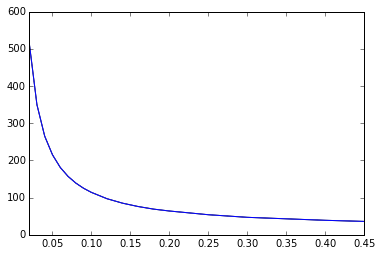

In [30]:
plot_as_gaussians(size, z)

Which is what we'd expect as all galaxies have the same image size for each redshift step.

# Photometric Params

**Morfometryka** fits both 1D and 2D sérsic profiles to each galaxy image giving us several photometric parameters to work with. For now, we're only concerned with the effective radii $R_n$ and the sérsic index $n$. 

## Effective Radii $R_n$

<div id="rnandn"></div>
Now, let's work with the Effective Radii (RnFit2D)

In [31]:
Rn = photo_catalogs[1].T.astype(float)

We can, for example, work with classes separately using the indexes from ''spirals'' and ''ellipticals'' as

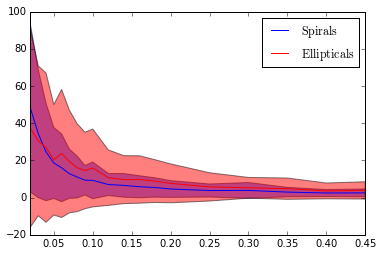

In [45]:
f, ax = plt.subplots(1, 1)
plot_as_gaussians(Rn[spirals], z, ax=ax, label=r'$\rm Spirals$')
plot_as_gaussians(Rn[ellipticals], z, ax=ax, color='red', label=r'$\rm Ellipticals$')
plt.legend(loc=1);

Solid lines shows means for each class and filled area shows $\pm 1\ \sigma$ fitted from a gaussian for each redshift. As we can see, the distributions follows the decreasing of the image resolution for obvious reasons. It is possible to recover the true value of $R_n$ by dividing it by the scale factor. We know that all images had $1024 \ x \ 1024 \ \rm pix^2$ prior the redshift simulations. So, recovering it is straightforward

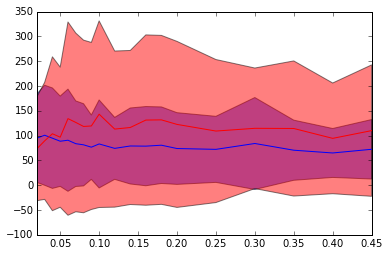

In [41]:
scale = 1024/size
Rn_correct = scale * Rn
f, ax = plt.subplots(1, 1)
plot_as_gaussians(Rn_correct[spirals], z, ax=ax)
plot_as_gaussians(Rn_correct[ellipticals], z, ax=ax, color='red')

The scattering in the ellipticals distribution is strange. Let's check that

<div id="spiking"></div>
# Spiking Effect (Sérsic 2D fit errors)

What is the overall behavior of $R_n$?

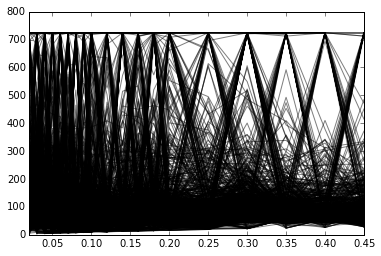

In [57]:
plt.plot(z, Rn_correct.T, '-k', alpha=0.5);
plt.xlim([z.min(), z.max()]);

This plot reveals some degree of error in our measurements. There is a spiking in some redshift slices due to Sérsic profile fitting errors, tracking those galaxies would be useful. We could do that by taking the derivative of our measurements and finding where there is a increase in the function since it is overall monotonic decreasing. Sure we would lose some information about ''natural'' increasing not due measurement erros, but in a whole this method works. We take the derivative for each galaxy and find which one has increasing regions (see **find_spiked** function in mfmtk-utils)

In [82]:
spiked, not_spiked = find_spiked(Rn, 1)

And then we have it

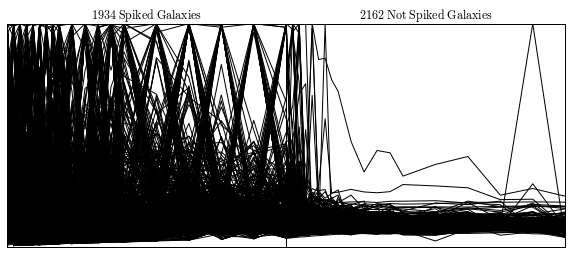

In [77]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
plt.subplots_adjust(wspace=0)
plt.xlim([z.min(), z.max()])
plt.xticks([])
plt.yticks([])
ax1.set_title(r'$' + str(np.size(spiked)) + '$' + r'$ \ \rm Spiked \ Galaxies$')
ax2.set_title(r'$' + str(np.size(not_spiked)) + '$' + r'$ \ \rm Not \ Spiked \ Galaxies$')
ax1.plot(z, Rn_correct[spiked].T, '-k')
ax2.plot(z, Rn_correct[not_spiked].T, '-k');

Almost half our sample has errors in the 2D sérsic fitting. Our objective is not to exclude these galaxies but to track them down and verify morfometryka's measurement on them. **galaxies[spiked]** give us every one of them but we would want only worst cases for it is a lot more easier to find the problem with them. We increase the threshold for 10 spikes so only galaxies showing 10 spikes are allowed in our selection

In [96]:
spiked, not_spiked = find_spiked(Rn, 10)
galaxies[spiked].tolist()

['PGC0027041',
 'PGC0031003',
 'PGC0034004',
 'PGC0046819',
 'PGC0047709',
 'PGC0056617',
 'PGC0057634',
 'PGC0059647',
 'PGC0060049']

We reduced our pool of galaxies from $\sim 2000$ to $9$. Let's write them in a catalog for future use

In [89]:
f = open('/data/worst_spiking_cases.mfmtk', 'w')
for gal in galaxies[spiked]:
    f.write(gal + '\n')
f.close()

## Sérsic Index $n$

<div id="sersicindex"></div>
Let's proceed to the Sérsic Index.

In [104]:
n = photo_catalogs[2].T.astype(float)

Since $n$ is also a Sérsic Profile parameter, we expect to find the same errors as $R_n$. Let's find spiked galaxies for $n$. In general, they must be the same galaxies that had spikes in $R_n$, but as $n$ and $R_n$ have two completely different behaviors ($n$ does not explicitly depends on resolution, for example) the idea is to find the spiked ones again.

In [220]:
spiked, not_spiked = find_spiked(n, 2)

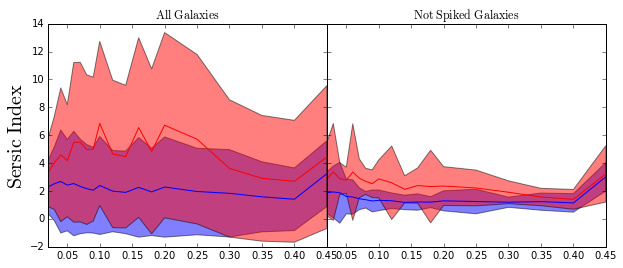

In [138]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
plt.subplots_adjust(wspace=0)
plot_as_gaussians(n[spirals], z, ax1, ylabel=r'$\rm Sersic \ Index$', title=r'$ \rm All \ Galaxies$')
plot_as_gaussians(n[ellipticals], z, ax1, color='Red')
plot_as_gaussians(n[intersect(spirals, not_spiked)], z, ax2, title=r'$ \rm Not \ Spiked \ Galaxies$')
plot_as_gaussians(n[intersect(ellipticals, not_spiked)], z, ax2, color='Red')

Our sample without spiked galaxies shows a huge difference from all the sample. Prior making any assumptions in both $R_n$ and $n$ we must check these errors. 

# Morphometric Parameters

Morphometric morphology is an alias to non-parametric morphology. It does not depend on profiles nor models and with that in mind we can proceed to analize our morphometric parameters without worryng about the errors found in the profile fitting. 

<div id="cs"></div>
## Concentrations $C_1$ and $C_2$

Concentrations measure the ratio between an outer radius and an inner radius. They are found by selecting %'s of light that each one have within it, giving us a measure of concentration. We usually use

$$ C_1 = \log_{10} \left ( \frac{R_{80}}{R_{20}} \right ) $$ $$ C_2 = \log_{10} \left ( \frac{R_{90}}{R_{50}} \right ) $$

As a concentration measurement, they also correlate with $n$. [see **Andrae et al. 2011**]

In [139]:
C1 = morpho_catalogs[0].astype(float).T/5
C2 = morpho_catalogs[1].astype(float).T/5

Distributions for $C_1$ and $C_2$ are

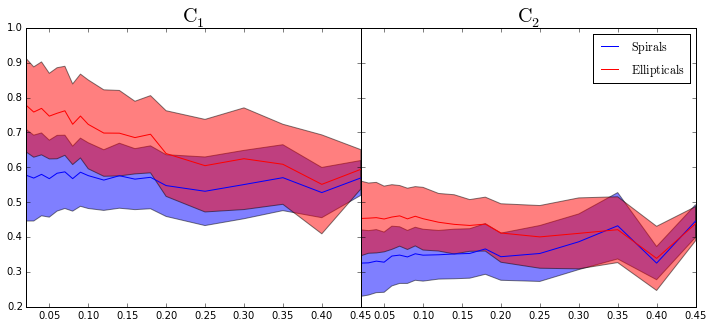

In [144]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 5))
plt.subplots_adjust(wspace=0)
ax1.set_xlim([0.02, 0.45])
plot_as_gaussians(C1[spirals], z, ax1, title=r'$\rm C_1$')
plot_as_gaussians(C1[ellipticals], z, ax1, color='red')
plot_as_gaussians(C2[spirals], z, ax2, title=r'$\rm C_2$', label=r'$\rm Spirals$')
plot_as_gaussians(C2[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')

plt.legend(loc=1);

The $C_1$ distributions for each redshift are

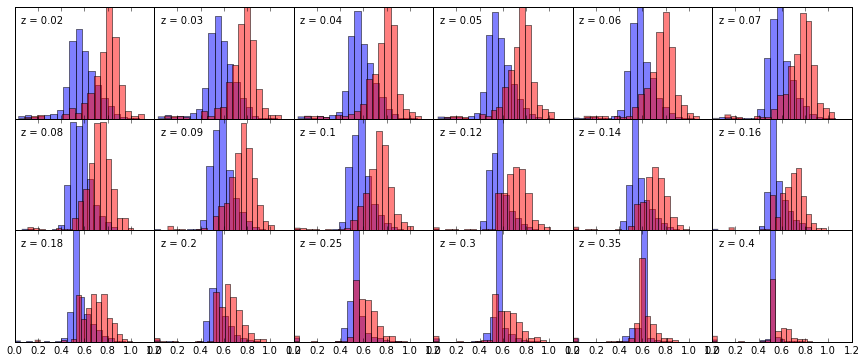

In [164]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(C1[spirals], z, axes, normed=1)
histograms(C1[ellipticals], z, axes, color='red', normed=1, xinfo=True)

the same for $C_2$ gives

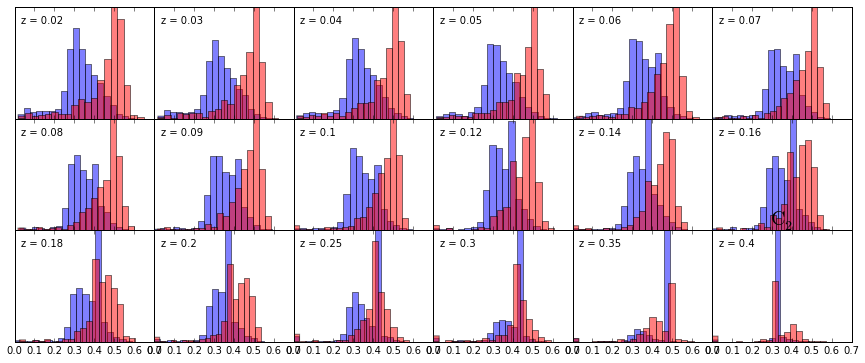

In [166]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(C2[spirals], z, axes, normed=1)
histograms(C2[ellipticals], z, axes, color='red', normed=1, xinfo=True)

<div id='asymmetries'></div>
## Asymmetries $A_1$ and $A_3$

In [167]:
A1 = morpho_catalogs[2].astype(float).T
A3 = morpho_catalogs[3].astype(float).T

Distributions for $A_1$ and $A_3$ are

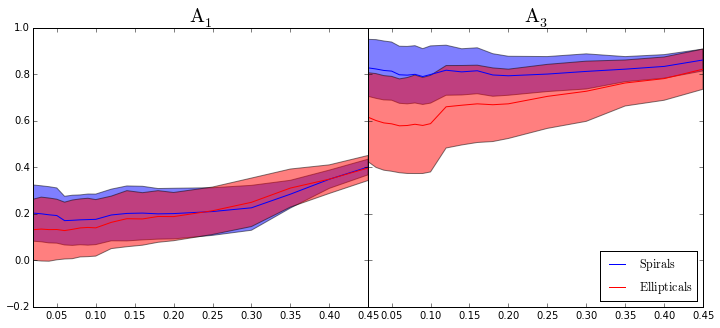

In [179]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 5))
plt.subplots_adjust(wspace=0)
ax1.set_xlim([0.02, 0.45])
plot_as_gaussians(A1[spirals], z, ax1, title=r'$\rm A_1$')
plot_as_gaussians(A1[ellipticals], z, ax1, color='red')
plot_as_gaussians(A3[spirals], z, ax2, title=r'$\rm A_3$', label=r'$\rm Spirals$')
plot_as_gaussians(A3[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=4);

Histograms for $A_1$

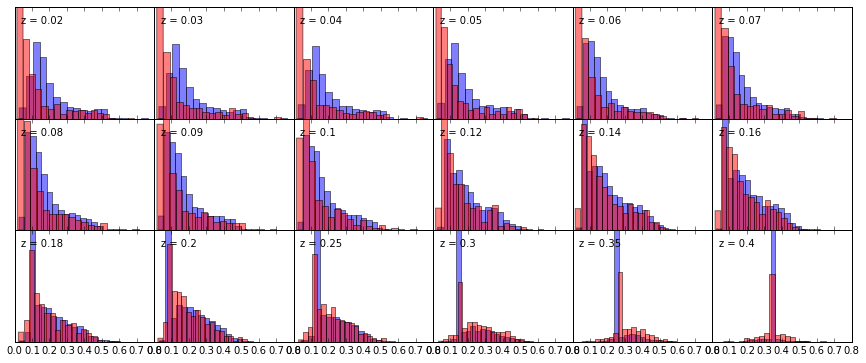

In [172]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(A1[spirals], z, axes, normed=1)
histograms(A1[ellipticals], z, axes, color='red', normed=1, xinfo=True)

Histograms for $A_3$

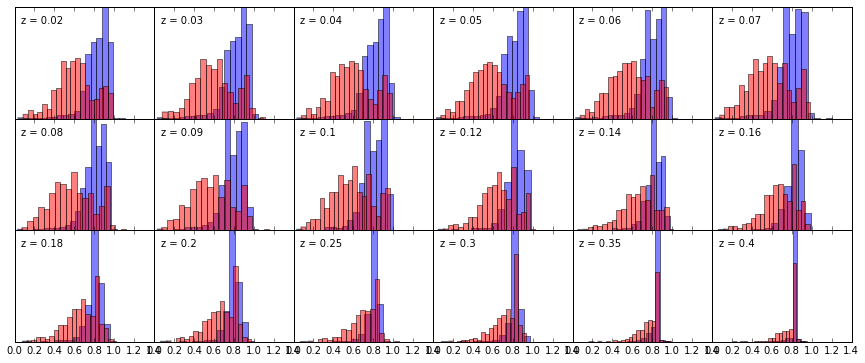

In [173]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(A3[spirals], z, axes, normed=1)
histograms(A3[ellipticals], z, axes, color='red', normed=1, xinfo=True)

<div id='smoothness'></div>
## Smoothness $S_1$ and $S_3$

In [195]:
S1 = morpho_catalogs[4].astype(float).T
S3 = morpho_catalogs[5].astype(float).T

Distributions for $S_1$ and $S_3$ are

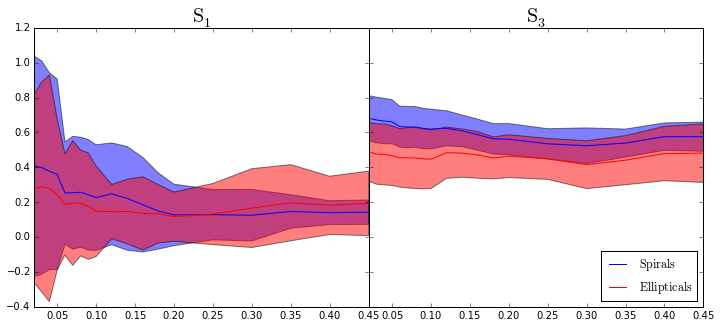

In [184]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 5))
plt.subplots_adjust(wspace=0)
ax1.set_xlim([0.02, 0.45])
plot_as_gaussians(S1[spirals], z, ax1, title=r'$\rm S_1$')
plot_as_gaussians(S1[ellipticals], z, ax1, color='red')
plot_as_gaussians(S3[spirals], z, ax2, title=r'$\rm S_3$', label=r'$\rm Spirals$')
plot_as_gaussians(S3[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=4);

Histograms for $S_1$

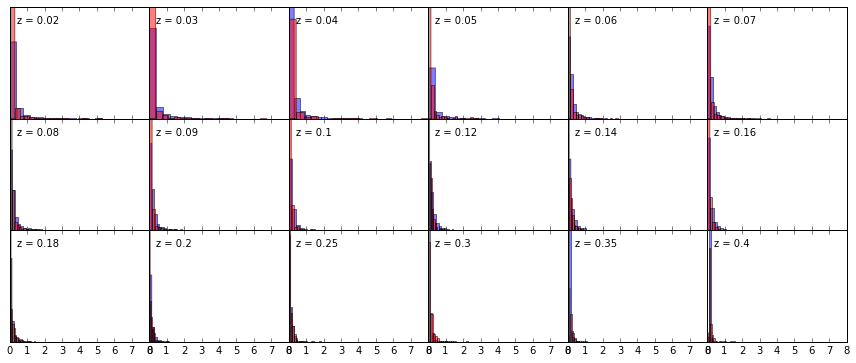

In [185]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(S1[spirals], z, axes, normed=1)
histograms(S1[ellipticals], z, axes, color='red', normed=1, xinfo=True)

Histograms for $S_3$

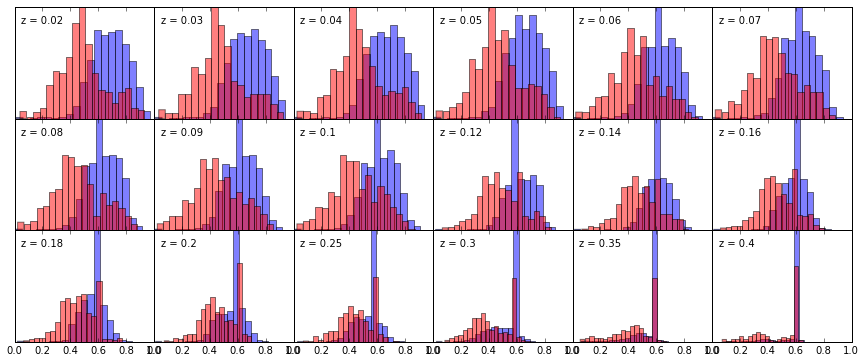

In [186]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(S3[spirals], z, axes, normed=1)
histograms(S3[ellipticals], z, axes, color='red', normed=1, xinfo=True)

<div id='giniH'></div>
## Gini $G$ and Entropy $H$

In [193]:
G = morpho_catalogs[6].astype(float).T
H = morpho_catalogs[7].astype(float).T

Gini $G$ and entropy $H$ distribution

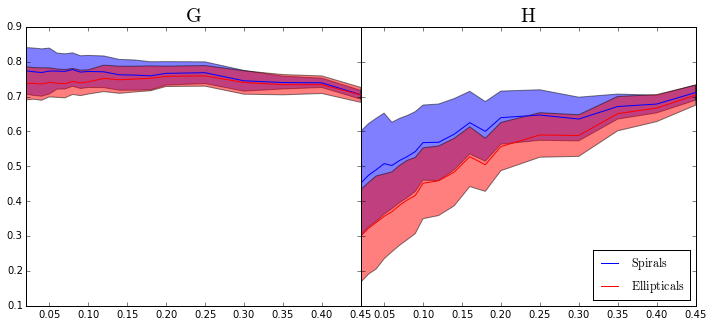

In [194]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 5))
plt.subplots_adjust(wspace=0)
ax1.set_xlim([0.02, 0.45])
plot_as_gaussians(G[spirals], z, ax1, title=r'$\rm G$')
plot_as_gaussians(G[ellipticals], z, ax1, color='red')
plot_as_gaussians(H[spirals], z, ax2, title=r'$\rm H$', label=r'$\rm Spirals$')
plot_as_gaussians(H[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=4);

Histograms for $G$

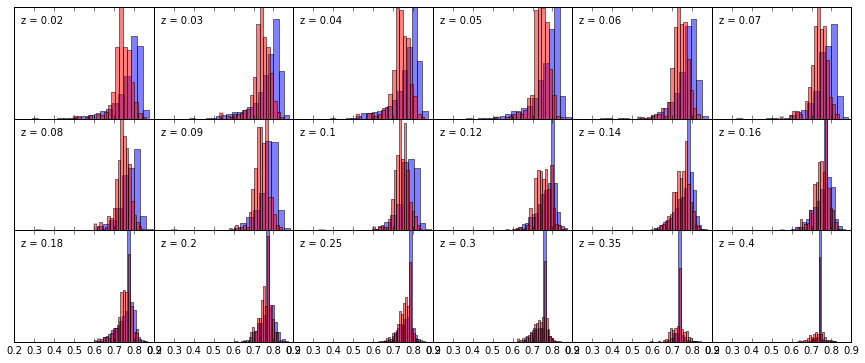

In [196]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(G[spirals], z, axes, normed=1)
histograms(G[ellipticals], z, axes, color='red', normed=1, xinfo=True)

Histograms for $H$

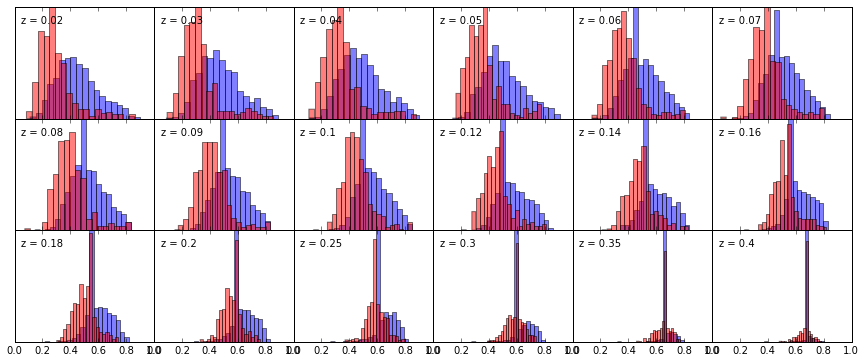

In [197]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(H[spirals], z, axes, normed=1)
histograms(H[ellipticals], z, axes, color='red', normed=1, xinfo=True)

<div id="sigmapsi"></div>
# Spirality $\sigma_\psi$

In [212]:
spsi = morpho_catalogs[9].astype(float).T

$\sigma_{\psi}$ distributions

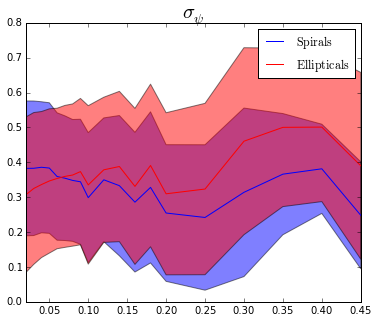

In [214]:
f, ax2 = plt.subplots(1,1, figsize=(6, 5))
plt.subplots_adjust(wspace=0)
ax2.set_xlim([0.02, 0.45])
plot_as_gaussians(spsi[spirals], z, ax2, title=r'$\rm \sigma_{\psi}$', label=r'$\rm Spirals$')
plot_as_gaussians(spsi[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=1);

Histograms

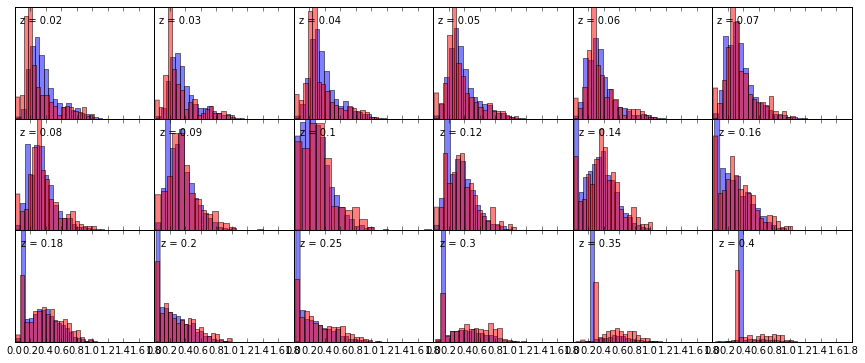

In [216]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(spsi[spirals], z, axes, normed=1)
histograms(spsi[ellipticals], z, axes, color='red', normed=1, xinfo=True)

<div id='m20'></div>
## $\rm M_{20}$

In [217]:
M20 = morpho_catalogs[8].astype(float).T

$M_{20}$ distribution is

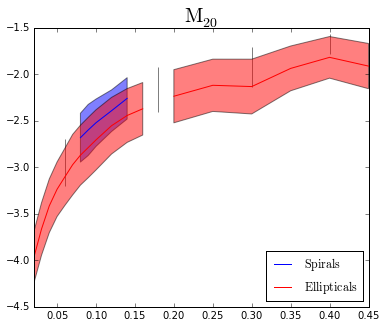

In [208]:
f, ax2 = plt.subplots(1,1, figsize=(6, 5))
plt.subplots_adjust(wspace=0)
ax2.set_xlim([0.02, 0.45])
plot_as_gaussians(M20[spirals], z, ax2, title=r'$\rm M_{20}$', label=r'$\rm Spirals$')
plot_as_gaussians(M20[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=4);

<div id="lda"> <div/>
# LDA - Linear Discriminant Analysis

Here, I am following the step-by-step guide for LDA available from [Raschka](http://sebastianraschka.com/Articles/2014_python_lda.html) website but adapted to our problem of two major galaxy morphological classes. We are going to performe LDA in $z = 0.02$ first.

In [220]:
data = catalog(path='/data/catalogs/FERENGI/SDSS/flux/0.02.mfmtk')
params = ['C1', 'A3', 'S3', 'H']
galaxies = data.raw_catalog[0]
classes = classes_indexes(galaxies, T_type)
data = data.param_selection(params)

$C_1$ is not in the correct range, we need to divide it by 5

In [221]:
data.T[0] = data.T[0]/5

So we have a NxM matrix where N is the numbers of features and M the total number of galaxies in our sample

In [222]:
N = 4

## Step 0: Feature Selection

The feature selection was already made by [Ferrari et al. 2015](http://arxiv.org/abs/1509.05430) for our set of parameters so I am skipping this step, using

$$\textbf{x}  = \{ C_1, A_3, S_3, H, \sigma_{\psi} \}$$

this particular feature selection agrees with the histograms in previous sections. The only thing to note is that $\sigma_{\psi}$seems to be worse here than in the graph showed in the paper.

## Step 1: Computing the d-dimensional mean vectors

We have to compute the mean vector $m_i$, $(i = 1, 2)$ for both classes. 

In [223]:
mean_vectors = []
for c in classes:
    mean_vectors.append(np.mean(data[c], axis=0))
mean_vectors

[array([ 0.60043081,  0.81140825,  0.65876853,  0.41487429]),
 array([ 0.74580511,  0.67444789,  0.54392054,  0.33599475])]

## Step 2: Computing the Scatter Matrices

### 2.1 Within-class scatter matrix $S_W$

The within-class scatter matrix $S_W$ follow: $$S_W = \sum^{\rm classe}_{i=1} S_i $$ where $$ S_i = \sum_{x}^{n} (\textbf{x} - \textbf{m_i})(\textbf{x} - \textbf{m_i})^T$$
where $\textbf{x}$ is our data and $m_i$ the mean vector for $i$th class.

In [224]:
SW = np.zeros(())
for c in classes:
    SW_temp = np.zeros((N,N))
    for galaxy in data[c]:
        galaxy, mv = galaxy.reshape(N, 1), mean_vectors[0].reshape(N,1)
        SW_temp += (galaxy-mv).dot((galaxy-mv).T)
    SW = SW + SW_temp

### 2.2 Between-class scatter matrix $S_B$

The between-class scatter matrix $S_B$ can be found by
$$ S_B = \sum_{i=1}^{\rm class} N_i ( \mathbf{m_i} - \mathbf{m} ) (\mathbf{m_i} - \mathbf{m})^T $$
where $\mathbf{m}$ is the overall mean, $\mathbf{m_i}$ is mean vector for $i$th class and $N_i$ is the sample size for given class.

In [225]:
overall_mean = np.mean(data, axis=0)
S_B = np.zeros((N,N))
for galclass, mv in zip(classes, mean_vectors):
    Ni = data[galclass].shape[0]
    mv = mv.reshape(N,1)
    overall_mean = overall_mean.reshape(N,1)
    S_B  += Ni* (mv - overall_mean).dot((mv-overall_mean).T)

## Step 3: Solving eigenvalue problem

With both matrix at hand $S_W$ and $S_B$ we can solve the eigenvalue problem for the matrix $S^{-1}_W S_B$

In [226]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(SW).dot(S_B))

Now it is useful to sort our eigenvectors and eigenvalues

In [227]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

Now we can see the significance of each one of our pairs

In [228]:
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

eigenvalue 1: 73.02%
eigenvalue 2: 26.98%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


Only two of the eigenvalues give us important information abour our system. We create our weight vector with the correspondent eigenvectors

In [229]:
W = np.hstack((eig_pairs[0][1].reshape(N,1), eig_pairs[1][1].reshape(N,1)))

Transform our data into our new space generated by the eigenvectors selected

In [230]:
data_lda = data.dot(W)

In [86]:
data_lda[:,0].real[spirals].shape

(407,)

Let's plot the results to check it

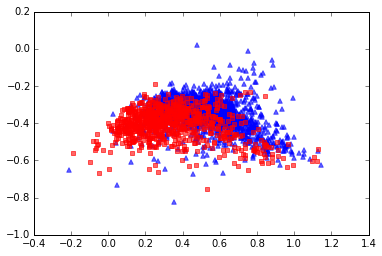

In [231]:
f, ax = plt.subplots(1,1)
for c, marker, color in zip(classes, ('^', 's'), ('blue', 'red')):
    ax.scatter(x=X_lda[:,0].real[c],
            y=X_lda[:,1].real[c],
            marker=marker,
            color=color,
            alpha=0.6)

## Step 4. Covariance Matrixes

The fisher's process is only made for dimensionality reduction, we still do not have a hyperplane to separate the classes. To do that, we will use a Bayesian approach as described in **Ferrari et al. 2015**. The first step towards it is to find the covariance matrix. In the case of a LDA, we consider identical matrixes for each class. It can be found by

$$ \Sigma_i = \frac{1}{N_i - 1} \sum_{\mathbf{x}}^{N} (\mathbf{x} - \mathbf{m_i}) (\mathbf{x} - \mathbf{m_i})^T $$

Let's do that for the spirals

In [232]:
mean_vectors = []
for c in classes:
    mean_vectors.append(np.mean(X_lda.real[c], axis=0))
mean_vectors

SIGMA = np.zeros((2,2))
for galaxy in X_lda.real[classes[0]]:
    galaxy, mv = galaxy.reshape(2, 1), mean_vectors[0].reshape(2,1)
    SIGMA += (galaxy-mv).dot((galaxy-mv).T)
Ni = data[classes[0]].shape[0]
SIGMA = 1./(Ni - 1) * SIGMA
SIGMA

array([[ 0.02994921, -0.00418622],
       [-0.00418622,  0.00720429]])

## Step 5. Prior Probabilities

To proceed with the Bayes approach to the classification, one must find the prior probability $P(C_i)$ for each $i$th class. This is usually done by finding the frequencies of occurrence of given class in the whole data, i.e, the probability of picking a galaxy of given class without any other information

$$ \pi_k = \frac{\# \rm \ galaxies \  in \ class \ k}{\# \ total \ number \ of \ galaxies}$$

In [233]:
prior = []
for c in classes:
    prior.append(X_lda.real[c].shape[0]/X_lda.real.shape[0])
prior

[0.411865234375, 0.208740234375]

## Discriminant Function

Our discriminant function is given by $$ f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}  + w_0 $$ anf following **Ferrari el al. 2015** we have
$$ \mathbf{w}  = \mathbf{\Sigma^{-1}} (\mathbf{\mu_1} - \mathbf{\mu_2)}$$ 
and the threshold $w_0$ is
$$ w_0 = \frac{1}{2} \mathbf{\mu_1}^{T} \mathbf{\Sigma}^{-1} \mathbf{\mu_1} + \frac{1}{2} \mathbf{\mu_2}^{T} \mathbf{\Sigma}^{-1} \mathbf{\mu_2} + \ln \frac{P(C_1)}{P(C_2)} $$

In [234]:
SIGMA_I = np.linalg.inv(SIGMA)
W = SIGMA_I.dot(mean_vectors[0] - mean_vectors[1])
w0 = np.log(prior[0]/prior[1]) - 0.5 * ((mean_vectors[0] + mean_vectors[1]).T.dot(SIGMA_I)).dot(mean_vectors[0]-mean_vectors[1])

In [188]:
x = - w0*W/(W.dot(W))
x, W.dot(x)

(array([-0.07014044, -0.11094028]), -2.0291847611116736)

In [211]:
def fc(x):
    return W.T.dot(x) + w0 

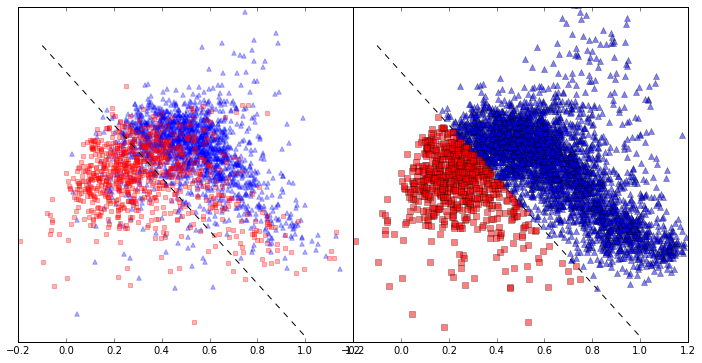

In [235]:
xx = np.linspace(-0.1, 1) 
a = -W[0] / W[1] 
yy = a * xx - w0 / W[1]

f, (ax, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 6))
plt.subplots_adjust(wspace=0)
plt.yticks([])
ax.plot(xx,yy, '--k')
ax2.plot(xx,yy, '--k')
plt.ylim([-0.8, 0])
plt.xlim([-0.2, 1.2])
for c, marker, color in zip(classes, ('^', 's'), ('blue', 'red')):
    ax.scatter(x=X_lda[:,0].real[c],
            y=X_lda[:,1].real[c],
            marker=marker,
            color=color,
            alpha=0.3)
    
for galaxy in X_lda.real:
    color = 'blue'
    marker = '^'
    if fc(galaxy) < 0:
        color = 'red'
        marker= 's'
    
    ax2.plot(galaxy[0], galaxy[1], marker=marker, color=color, alpha=0.5)

In [136]:
def f(x):
    return W.T.dot(x) + w0

## Example: Fisher's LDA on each redshift step

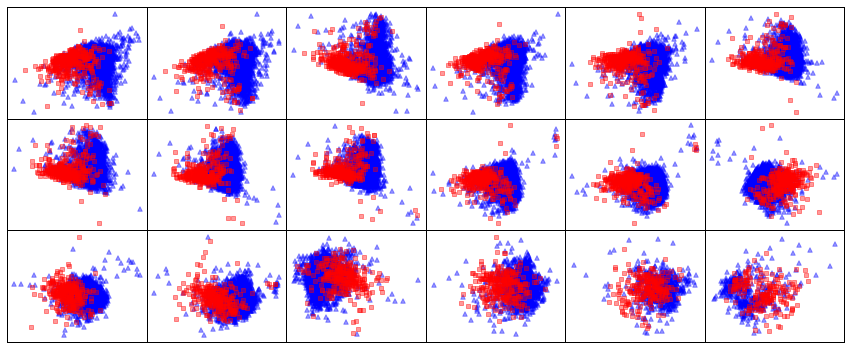

In [59]:
params = ['C1', 'A3', 'S3', 'H', 'sigma_psi']

ldas = []
f, axes = plt.subplots(3, 6, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
for zi, ax in zip(redshifts, axes.flat):
    data = catalog(path='/data/catalogs/FERENGI/SDSS/flux/' + zi + '.mfmtk')
    galaxies = data.raw_catalog[0]

    E_indexes = T_type.T[np.where(T_type[1].astype(float) < -2)].T[0]
    S_indexes = T_type.T[np.where((T_type[1].astype(float) >= 1) & (T_type[1].astype(float) < 7))].T[0]
    spirals = np.array([i for i, val in enumerate(galaxies) if val in set(S_indexes)])
    ellipticals = np.array([i for i, val in enumerate(galaxies) if val in set(E_indexes)])

    data = data.param_selection(params)
    X_lda = fisher_lda(data, np.size(params), [spirals, ellipticals])
    ax.set_xticks([])
    ax.set_yticks([])
    for label, marker, color in zip((spirals, ellipticals), ('^', 's'),('blue', 'red')):
        ax.scatter(x=X_lda[:,0].real[label],
                    y=X_lda[:,1].real[label],
                    marker=marker,
                    color=color,
                    alpha=0.4)


<div id="appclass"> </div>
# Appendix A: The Catalog class

<div id="appB"></div>
# Appendix B: Plotting Utilities